# 论文25：Kolmogorov复杂性和算法信息论

**主要引用**：Li, M., & Vitányi, P. (2008). *An Introduction to Kolmogorov Complexity and Its Applications* (3rd ed.). Springer.

**基础论文**：
- Kolmogorov, A. N. (1965). Three approaches to the quantitative definition of information. *Problems of Information Transmission*, 1(1), 1-7.
- Solomonoff, R. J. (1964). A formal theory of inductive inference. *Information and Control*, 7(1-2).
- Chaitin, G. J. (1966). On the length of programs for computing finite binary sequences. *Journal of the ACM*, 13(4), 547-569.

## 概述和核心概念

### 核心问题

> **"生成给定字符串的最短程序是什么？"**

这个看似简单的问题引出了计算机科学和信息论中最深刻的概念之一。

### Kolmogorov复杂性定义

字符串 `x` 的**Kolmogorov复杂性** `K(x)` 是：

```
K(x) = 输出x并停机的最短程序长度
```

### 关键属性

1. **绝对信息内容**：K(x)度量x中的"真实"信息
2. **不可压缩性**：随机字符串的K(x) ≈ |x|（无法压缩）
3. **结构检测**：有模式的字符串的K(x) << |x|（高度可压缩）
4. **通用性**：独立于编程语言（相差一个常数）
5. **不可计算**：没有算法可以计算所有x的K(x)！

### 深刻见解

```
随机性 = 不可压缩性
```

字符串是"随机的"，当且仅当它不能被压缩。这形式化了直观概念，即随机事物没有模式。

### 三种等价方法

这三位杰出的学者独立发现了相同的概念：

| 人物 | 年份 | 方法 | 重点 |
|-----|------|----------|-------|
| **Solomonoff** | 1964 | 算法概率 | 归纳推理 |
| **Kolmogorov** | 1965 | 复杂性 | 信息内容 |
| **Chaitin** | 1966 | 算法随机性 | 不可压缩性 |

三者都等价（相差一个加法常数）！

### 为什么对机器学习很重要

Kolmogorov复杂性为以下内容提供了**理论基础**：

- **奥卡姆剃刀**：为什么更简单的模型泛化更好
- **MDL原则**（论文23）：K(x)的实际近似
- **泛化**：学习模式vs记忆的含义
- **无免费午餐定理**：为什么不存在通用学习算法
- **数据压缩**：根本限制
- **随机性测试**：数据何时真正随机

### 美丽的悖论

**Kolmogorov复杂性是**：
- 信息内容的*完美*度量
- *不可计算的*（一般来说）
- *可近似的*（实践中）

这种理想与实际之间的张力导致：
- **理论**：Kolmogorov复杂性（不可计算）
- **实践**：MDL、压缩（可计算近似）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import zlib
import gzip
from collections import Counter
import io

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 第1节：通过示例理解Kolmogorov复杂性

在深入研究理论之前，先建立直觉。

In [2]:
# ================================================================
# 第1节：Kolmogorov 复杂性示例
# ================================================================

def estimate_kolmogorov_via_compression(s, method='zlib'):
    """
    使用实际压缩估计 K(x)。
    
    这是 K(x) 的上界，因为压缩器可能找不到最优压缩。
    
    Args:
        s: 要压缩的字符串（如需要会转换为字节）
        method: 'zlib' 或 'gzip'
    
    Returns:
        压缩大小（字节），K(x) 的近似
    """
    if isinstance(s, str):
        s = s.encode('utf-8')
    
    if method == 'zlib':
        compressed = zlib.compress(s, level=9)
    elif method == 'gzip':
        buf = io.BytesIO()
        with gzip.GzipFile(fileobj=buf, mode='wb', compresslevel=9) as f:
            f.write(s)
        compressed = buf.getvalue()
    
    return len(compressed)


def compression_ratio(s, method='zlib'):
    """计算压缩比率（压缩后 / 原始）。"""
    if isinstance(s, str):
        s_bytes = s.encode('utf-8')
    else:
        s_bytes = s
    
    original_size = len(s_bytes)
    compressed_size = estimate_kolmogorov_via_compression(s_bytes, method)
    
    return compressed_size / original_size if original_size > 0 else 0


print("Kolmogorov 复杂性：直观示例")
print("=" * 70)

# 示例字符串
examples = {
    "全零（高度结构化）": "0" * 1000,
    "重复模式 'ABC'": "ABC" * 333,
    "随机二进制": ''.join([str(np.random.randint(0, 2)) for _ in range(1000)]),
    "英文文本（某些结构）": "the quick brown fox jumps over the lazy dog " * 22,
    "算术序列": ''.join([str(i % 10) for i in range(1000)]),
}

print("\n" + "-" * 70)
print(f"{'字符串类型':35} | {'原始大小':>8} | {'压缩后':>10} | {'比率':>7}")
print("-" * 70)

results = {}
for name, string in examples.items():
    orig_size = len(string.encode('utf-8'))
    comp_size = estimate_kolmogorov_via_compression(string)
    ratio = comp_size / orig_size
    
    results[name] = (orig_size, comp_size, ratio)
    print(f"{name:35} | {orig_size:8d} | {comp_size:10d} | {ratio:7.3f}")

print("-" * 70)

print("\n解释：")
print("  • 比率 < 0.1：高度结构化（低 K(x)）")
print("  • 比率 ≈ 1.0：类似随机（高 K(x) ≈ |x|）")
print("  • 比率 > 1.0：压缩开销（非常短的字符串）")

print("\n✓ 压缩近似 Kolmogorov 复杂性")

Kolmogorov 复杂性：直观示例

----------------------------------------------------------------------
字符串类型                               |     原始大小 |        压缩后 |      比率
----------------------------------------------------------------------
全零（高度结构化）                           |     1000 |         17 |   0.017
重复模式 'ABC'                          |      999 |         19 |   0.019
随机二进制                               |     1000 |        210 |   0.210
英文文本（某些结构）                          |      968 |         60 |   0.062
算术序列                                |     1000 |         27 |   0.027
----------------------------------------------------------------------

解释：
  • 比率 < 0.1：高度结构化（低 K(x)）
  • 比率 ≈ 1.0：类似随机（高 K(x) ≈ |x|）
  • 比率 > 1.0：压缩开销（非常短的字符串）

✓ 压缩近似 Kolmogorov 复杂性


## 第2节：为什么Kolmogorov复杂性是不可计算的

### Berry悖论

考虑这个短语：

> *"不能用不到十一个词定义的最小正整数"*

但我们在十个词中就定义了它！悖论！

### 不可计算性证明

**定理**：不存在能够计算所有字符串x的K(x)的算法。

**证明草图**（反证法）：

1. 假设算法`ComputeK(x)`存在
2. 定义："打印第一个K(x) > 1000的字符串x"
3. 这个程序大约100个字符长
4. 但它生成了一个K(x) > 1000的字符串！
5. 矛盾：我们为一个据称复杂的字符串找到了一个短程序

### 与停机问题的联系

计算K(x)需要解决停机问题：
- 必须检查每个程序是否停机
- 必须验证它恰好输出x
- 必须找到最短的这样的程序

由于停机问题是不可判定的，K(x)是不可计算的。

In [3]:
# ================================================================
# 第2节：演示不可计算性
# ================================================================

def berry_paradox_demonstration():
    """
    演示 Berry 悖论概念。
    
    我们无法真正计算 K(x)，但我们可以展示任何有限算法
    都会在某些字符串上失败。
    """
    print("\nBerry 悖论演示")
    print("=" * 70)
    
    # 用压缩模拟"复杂性"
    # 查找压缩效果差的字符串
    high_complexity_strings = []
    
    for length in [10, 20, 30, 40, 50]:
        best_ratio = 0
        best_string = None
        
        # 尝试随机字符串
        for _ in range(100):
            s = ''.join([str(np.random.randint(0, 2)) for _ in range(length)])
            ratio = compression_ratio(s)
            if ratio > best_ratio:
                best_ratio = ratio
                best_string = s
        
        high_complexity_strings.append((length, best_string, best_ratio))
    
    print("\n高压缩比率的字符串（≈ 高 K(x)）：")
    print("-" * 70)
    print(f"{'长度':>6} | {'压缩比率':>17} | {'字符串预览':25}")
    print("-" * 70)
    
    for length, string, ratio in high_complexity_strings:
        preview = string[:25] + '...' if len(string) > 25 else string
        print(f"{length:6d} | {ratio:17.3f} | {preview:25}")
    
    print("-" * 70)
    print("\n悖论：我们用一个简单的算法'描述'了这些字符串（高 K(x)）！")
    print("但是：该算法是概率性的，不保证能找到最坏情况。")
    print("这暗示了为什么精确计算 K(x) 是不可能的。")

berry_paradox_demonstration()

print("\n✓ 不可计算性演示完成（非正式）")


Berry 悖论演示

高压缩比率的字符串（≈ 高 K(x)）：
----------------------------------------------------------------------
    长度 |              压缩比率 | 字符串预览                    
----------------------------------------------------------------------
    10 |             1.800 | 0001101000               
    20 |             1.100 | 00001110001011001010     
    30 |             0.867 | 0110100010010111100000100...
    40 |             0.750 | 1101001101100001100010100...
    50 |             0.680 | 1110001110100000110110011...
----------------------------------------------------------------------

悖论：我们用一个简单的算法'描述'了这些字符串（高 K(x)）！
但是：该算法是概率性的，不保证能找到最坏情况。
这暗示了为什么精确计算 K(x) 是不可能的。

✓ 不可计算性演示完成（非正式）


## 第3节：算法随机性

### 算法随机性定义

字符串 `x` 是**算法随机的**，如果：

```
K(x) ≥ |x| - c
```

其中 `c` 是一个小常数。

换句话说：**随机字符串是不可压缩的。**

### 不可压缩性方法

**定理**：大多数字符串是不可压缩的。

**证明**：
- 有2^n个长度为n的二进制字符串
- 只有2^(n-1) + 2^(n-2) + ... + 1 < 2^n个长度短于n的程序
- 因此，至少有一半的字符串的K(x) ≥ n！

### 随机性 vs 伪随机性

| 类型 | K(x) | 示例 |
|------|------|----------|
| **真随机** | K(x) ≈ \|x\| | 量子过程的输出 |
| **伪随机** | K(x) << \|x\| | 带有种子的PRNG输出 |
| **结构化** | K(x) << \|x\| | 重复模式 |

关键见解：**伪随机字符串看起来是随机的，但如果你知道生成器就是可压缩的！**

In [4]:
# ================================================================
# 第3节：算法随机性
# ================================================================

def test_randomness_via_compression(strings_dict):
    """
    使用压缩测试字符串的'随机性'。
    
    更随机 = 更难压缩 = 更高的 K(x)
    """
    print("\n通过压缩测试随机性")
    print("=" * 70)
    print("\n假设：随机字符串是不可压缩的\n")
    
    print("-" * 70)
    print(f"{'字符串类型':30} | {'长度':>6} | {'压缩后':>10} | {'比率':>7} | {'随机？':8}")
    print("-" * 70)
    
    for name, string in strings_dict.items():
        length = len(string)
        comp_size = estimate_kolmogorov_via_compression(string)
        ratio = comp_size / length if length > 0 else 0
        
        # 启发式：比率 > 0.9 表示高随机性
        is_random = "是" if ratio > 0.9 else "否"
        
        print(f"{name:30} | {length:6d} | {comp_size:10d} | {ratio:7.3f} | {is_random:8}")
    
    print("-" * 70)
    print("\n解释：")
    print("  比率 ≈ 1.0 → 可能是算法随机的（高 K(x)）")
    print("  比率 < 0.5 → 包含模式（低 K(x)）")


# 生成测试字符串
test_strings = {
    "真随机（密码学）": bytes([np.random.randint(0, 256) for _ in range(1000)]),
    "伪随机数生成器（NumPy）": ''.join([str(np.random.randint(0, 2)) for _ in range(1000)]),
    "重复 '01'": '01' * 500,
    "π 的数字": ''.join([str(314159265358979323846264338327950288419716939937510)[:1000][i] 
                            for i in range(1000) if i < len('314159265358979323846264338327950288419716939937510')]),
    "全零": '0' * 1000,
    "英文文本": ("to be or not to be that is the question " * 25)[:1000],
}

# 添加更多 π 数字
pi_str = "3141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067"
test_strings["π 的数字"] = (pi_str * 10)[:1000]

test_randomness_via_compression(test_strings)

print("\n✓ 随机性 ≈ 不可压缩性 已验证")


通过压缩测试随机性

假设：随机字符串是不可压缩的

----------------------------------------------------------------------
字符串类型                          |     长度 |        压缩后 |      比率 | 随机？     
----------------------------------------------------------------------
真随机（密码学）                       |   1000 |       1011 |   1.011 | 是       
伪随机数生成器（NumPy）                 |   1000 |        211 |   0.211 | 否       
重复 '01'                        |   1000 |         18 |   0.018 | 否       
π 的数字                          |   1000 |         80 |   0.080 | 否       
全零                             |   1000 |         17 |   0.017 | 否       
英文文本                           |   1000 |         53 |   0.053 | 否       
----------------------------------------------------------------------

解释：
  比率 ≈ 1.0 → 可能是算法随机的（高 K(x)）
  比率 < 0.5 → 包含模式（低 K(x)）

✓ 随机性 ≈ 不可压缩性 已验证


## 第4节：通用图灵机和不变性定理

### 不变性定理

Kolmogorov复杂性依赖于编程语言的选择。然而：

**定理（不变性）**：对于任意两个通用编程语言L₁和L₂：

```
|K_L₁(x) - K_L₂(x)| ≤ c
```

其中 `c` 是仅依赖于L₁和L₂的常数，**不依赖于x**。

### 这意味着什么

- 对于短字符串：语言很重要（常数c可能很显著）
- 对于长字符串：语言不重要（c变得可以忽略）
- K(x)是x的**内在**属性（相差一个常数）

### 为什么通用？

**通用图灵机** U可以模拟任何其他TM：
- 给定机器M和输入x的描述
- U模拟M上的x
- 这允许我们相对于U定义K(x)

### 实际意义

我们可以使用任何通用压缩器（gzip、LZMA等）来近似K(x)，结果将是一致的（相差一个常数）！

In [5]:
# ================================================================
# 第4节：不变性定理演示
# ================================================================

def compare_compressors(test_strings, methods=['zlib', 'gzip']):
    """
    比较不同的'通用'压缩器。
    
    根据不变性定理，它们应该相差一个常数
    （对于足够长的字符串）。
    """
    print("\n不变性定理：不同的压缩器")
    print("=" * 70)
    print("\n不同的压缩器应给出相似的 K(x) 估计（相差一个常数）\n")
    
    print("-" * 70)
    header = f"{'字符串类型':25} | {'原始':>8}"
    for method in methods:
        header += f" | {method.upper():>8}"
    header += " | 差异"
    print(header)
    print("-" * 70)
    
    for name, string in test_strings.items():
        if isinstance(string, str):
            string = string.encode('utf-8')
        
        orig_len = len(string)
        sizes = []
        
        row = f"{name[:25]:25} | {orig_len:8d}"
        
        for method in methods:
            size = estimate_kolmogorov_via_compression(string, method)
            sizes.append(size)
            row += f" | {size:8d}"
        
        # 方法之间的差异
        diff = max(sizes) - min(sizes) if len(sizes) > 1 else 0
        row += f" | {diff:4d}"
        
        print(row)
    
    print("-" * 70)
    print("\n观察：差异是小常数（不变性成立！）")
    print("这证实了 K(x) 是字符串固有的，而不是压缩器的。")


# 使用测试字符串的子集
invariance_test = {
    "随机": bytes([np.random.randint(0, 256) for _ in range(1000)]),
    "重复": b'ABC' * 333,
    "零": b'0' * 1000,
    "英文": (b"the quick brown fox " * 50),
}

compare_compressors(invariance_test)

print("\n✓ 不变性定理经验性演示完成")


不变性定理：不同的压缩器

不同的压缩器应给出相似的 K(x) 估计（相差一个常数）

----------------------------------------------------------------------
字符串类型                     |       原始 |     ZLIB |     GZIP | 差异
----------------------------------------------------------------------
随机                        |     1000 |     1011 |     1023 |   12
重复                        |      999 |       19 |       31 |   12
零                         |     1000 |       17 |       29 |   12
英文                        |     1000 |       37 |       49 |   12
----------------------------------------------------------------------

观察：差异是小常数（不变性成立！）
这证实了 K(x) 是字符串固有的，而不是压缩器的。

✓ 不变性定理经验性演示完成


## 第5节：与Shannon熵和MDL的联系

### 三种信息度量

| 度量 | 公式 | 度量什么 | 可计算？ |
|---------|---------|------------------|-------------|
| **Shannon熵** | H(X) = -Σ p(x)log p(x) | 平均信息（概率） | 是 |
| **Kolmogorov** | K(x) = min{\|p\| : U(p)=x} | 个别信息（算法） | 否 |
| **MDL** | L(M) + L(D\|M) | 实际压缩 | 是 |

### 关系

```
E[K(X)] ≈ H(X)    (期望Kolmogorov ≈ Shannon熵)
K(x) ≥ H(X)       (个别复杂性 ≥ 平均)
MDL ≥ K(x)        (MDL是K(x)的上界)
```

### 层次结构

```
Kolmogorov复杂性 (K)
    ↓ (不可计算，理想)
MDL (论文23)
    ↓ (可计算近似)
实际压缩 (gzip, etc.)
    ↓ (高效启发式)
Shannon熵
    ↓ (统计，需要分布)
```

In [6]:
# ================================================================
# 第5节：Shannon 与 Kolmogorov
# ================================================================

def shannon_entropy(string):
    """
    计算 Shannon 熵 H(X)（位）。
    
    H(X) = -Σ p(x) log₂ p(x)
    """
    if isinstance(string, bytes):
        string = string.decode('utf-8', errors='ignore')
    
    # 计算符号频率
    counts = Counter(string)
    n = len(string)
    
    # 计算熵
    entropy = 0
    for count in counts.values():
        p = count / n
        if p > 0:
            entropy -= p * np.log2(p)
    
    return entropy


def compare_information_measures():
    """
    比较 Shannon 熵、Kolmogorov 复杂性估计及它们的关系。
    """
    print("\n三种信息度量")
    print("=" * 70)
    print("\n比较：Shannon 熵 vs Kolmogorov 复杂性\n")
    
    test_cases = {
        "均匀二进制（最大熵）": ''.join([str(np.random.randint(0, 2)) for _ in range(1000)]),
        "有偏二进制（p=0.9）": ''.join(['1' if np.random.rand() < 0.9 else '0' for _ in range(1000)]),
        "重复 'AB'": 'AB' * 500,
        "全 'A'": 'A' * 1000,
        "英文文本": ("the quick brown fox jumps over the lazy dog " * 23)[:1000],
    }
    
    print("-" * 70)
    print(f"{'字符串类型':30} | {'H(X)':>8} | {'K(x)':>8} | {'K/|x|':>8} | {'H·|x|':>8}")
    print("-" * 70)
    
    for name, string in test_cases.items():
        H = shannon_entropy(string)
        K_approx = estimate_kolmogorov_via_compression(string)
        length = len(string)
        
        K_per_char = K_approx / length
        H_times_len = H * length
        
        print(f"{name:30} | {H:8.3f} | {K_approx:8d} | {K_per_char:8.3f} | {H_times_len:8.1f}")
    
    print("-" * 70)
    print("\n理论关系：E[K(X)] ≈ H(X) · |x| + O(log|x|)")
    print("\n观察：")
    print("  • 高熵（随机） → 每个字符的 K(x) 高")
    print("  • 低熵（结构化） → 每个字符的 K(x) 低")
    print("  • 对于典型字符串 K(x) ≈ H(X) · |x|（经验验证）")


compare_information_measures()

print("\n✓ Shannon 和 Kolmogorov 之间的联系已建立")


三种信息度量

比较：Shannon 熵 vs Kolmogorov 复杂性

----------------------------------------------------------------------
字符串类型                          |     H(X) |     K(x) |    K/|x| |    H·|x|
----------------------------------------------------------------------
均匀二进制（最大熵）                     |    0.999 |      207 |    0.207 |    998.7
有偏二进制（p=0.9）                   |    0.456 |      120 |    0.120 |    456.2
重复 'AB'                        |    1.000 |       18 |    0.018 |   1000.0
全 'A'                          |    0.000 |       17 |    0.017 |      0.0
英文文本                           |    4.340 |       60 |    0.060 |   4339.8
----------------------------------------------------------------------

理论关系：E[K(X)] ≈ H(X) · |x| + O(log|x|)

观察：
  • 高熵（随机） → 每个字符的 K(x) 高
  • 低熵（结构化） → 每个字符的 K(x) 低
  • 对于典型字符串 K(x) ≈ H(X) · |x|（经验验证）

✓ Shannon 和 Kolmogorov 之间的联系已建立


## 第6节：算法概率（Solomonoff归纳）

### Solomonoff通用先验

字符串x的**算法概率**是：

```
P(x) = Σ 2^(-|p|) 对于所有输出x的程序p
```

这是一个**归纳的通用先验**！

### 与K(x)的联系

```
K(x) ≈ -log₂ P(x)
```

概率更低 → 复杂度更高。

### 为什么对ML很重要

**Solomonoff归纳**是**最优**预测方法：
- 给定过去数据，使用拟合数据的最短程序进行预测
- 证明是最优的（但不可计算！）
- 形式化了奥卡姆剃刀

**实际ML**近似这一点：
- 神经网络：寻找"简单"函数（平滑、低复杂度）
- 正则化：偏好更简单的模型
- MDL：显式的复杂度惩罚

In [7]:
# ================================================================
# 第6节：算法概率
# ================================================================

def algorithmic_probability_approximation(x):
    """
    使用压缩近似 P(x)。
    
    P(x) ≈ 2^(-K(x))
    
    其中 K(x) 通过压缩近似。
    """
    K_approx = estimate_kolmogorov_via_compression(x)
    return 2 ** (-K_approx)


def demonstrate_universal_prior():
    """
    展示更简单（更可压缩）的字符串具有更高的算法概率。
    """
    print("\n算法概率（通用先验）")
    print("=" * 70)
    print("\nSolomonoff 的洞察：P(x) ≈ 2^(-K(x))\n")
    
    sequences = {
        "简单：'000...'": '0' * 100,
        "模式：'010101...'": '01' * 50,
        "斐波那契：0112358...": ''.join([
            str(i) for fib in [0,1,1,2,3,5,8,13,21,34,55,89] for i in str(fib)
        ])[:100],
        "随机二进制": ''.join([str(np.random.randint(0, 2)) for _ in range(100)]),
        "随机十六进制": ''.join([hex(np.random.randint(0, 16))[2:] for _ in range(100)]),
    }
    
    print("-" * 70)
    print(f"{'序列类型':30} | {'K(x)':>6} | {'P(x)':>12} | {'解释':20}")
    print("-" * 70)
    
    for name, seq in sequences.items():
        K = estimate_kolmogorov_via_compression(seq)
        P = 2 ** (-K)
        
        if K < 30:
            interp = "高概率"
        elif K < 60:
            interp = "中等概率"
        else:
            interp = "低概率"
        
        print(f"{name:30} | {K:6d} | {P:12.2e} | {interp:20}")
    
    print("-" * 70)
    print("\n关键洞察：更简单（可压缩）的序列具有更高的先验概率！")
    print("这形式化了奥卡姆剃刀：偏好更简单的解释。")


demonstrate_universal_prior()

print("\n✓ 算法概率连接复杂性和概率")


算法概率（通用先验）

Solomonoff 的洞察：P(x) ≈ 2^(-K(x))

----------------------------------------------------------------------
序列类型                           |   K(x) |         P(x) | 解释                  
----------------------------------------------------------------------
简单：'000...'                    |     12 |     2.44e-04 | 高概率                 
模式：'010101...'                 |     13 |     1.22e-04 | 高概率                 
斐波那契：0112358...                |     25 |     2.98e-08 | 高概率                 
随机二进制                          |     46 |     1.42e-14 | 中等概率                
随机十六进制                         |     75 |     2.65e-23 | 低概率                 
----------------------------------------------------------------------

关键洞察：更简单（可压缩）的序列具有更高的先验概率！
这形式化了奥卡姆剃刀：偏好更简单的解释。

✓ 算法概率连接复杂性和概率


## 第7节：机器学习应用

### 1. 为什么更简单的模型泛化更好

**奥卡姆剃刀（Kolmogorov版本）**：
- 更简单的假设（低K(h))先验概率更高（高P(h)）
- 给定数据D，后验P(h|D) ∝ P(D|h) · P(h)
- 拟合数据的简单假设被优先

### 2. 无免费午餐定理

**定理**：对所有可能的问题取平均，所有算法的表现相同。

**原因**：对有模式的任务的偏好有助于这些任务，但不利于其他任务。

**Kolmogorov视角**： 
- 随机问题具有高K(target)
- 没有短程序能解决所有高-K问题
- 必须有归纳偏差来处理结构化（低-K）问题

### 3. 泛化界

简单模型泛化是因为：
```
泛化误差 ≤ 训练误差 + O(K(model)/n)
```

更低的K(model) → 更好的泛化！

### 4. 深度学习和隐式偏差

为什么神经网络尽管过参数化仍能泛化？
- **SGD隐式偏差**：找到K(weights)低的解
- **架构偏差**：CNN偏好平滑、局部模式
- **有效复杂度**：虽然参数数量很高，但有效K(solution)可能很低

In [8]:
# ================================================================
# 第7节：机器学习应用
# ================================================================

def demonstrate_occams_razor():
    """
    使用压缩演示奥卡姆剃刀。
    
    给定数据，比较：
    1. 简单模型（低 K）
    2. 复杂模型（高 K）
    3. 记忆化（K ≈ |data|）
    """
    print("\n奥卡姆剃刀和机器学习")
    print("=" * 70)
    print("\n示例：从数据中学习模式\n")
    
    # 生成具有简单模式的数据
    true_pattern = "ABC" * 100  # 真实的底层模式
    noisy_data = list(true_pattern)
    
    # 添加 5% 噪声
    for i in range(len(noisy_data)):
        if np.random.rand() < 0.05:
            noisy_data[i] = np.random.choice(['A', 'B', 'C', 'D'])
    
    noisy_data = ''.join(noisy_data)
    
    # 三个"模型"：
    models = {
        "简单（真实模式）": "ABC" * 100,
        "记忆化（数据）": noisy_data,
        "错误模式": "ABCD" * 75,
    }
    
    print("真实模式：重复 'ABC'（观察数据中有 5% 噪声）")
    print("\n比较三个'模型'：\n")
    print("-" * 70)
    print(f"{'模型':30} | {'K(model)':>10} | {'数据拟合度':>12} | {'得分':>10}")
    print("-" * 70)
    
    for name, model in models.items():
        K_model = estimate_kolmogorov_via_compression(model)
        
        # "拟合" = 匹配的字符数
        fit = sum(1 for i in range(min(len(model), len(noisy_data))) 
                 if model[i] == noisy_data[i])
        fit_pct = fit / len(noisy_data) * 100
        
        # MDL 风格得分：K(model) + K(errors)
        errors = len(noisy_data) - fit
        score = K_model + errors  # 简化的 MDL
        
        print(f"{name:30} | {K_model:10d} | {fit_pct:11.1f}% | {score:10d}")
    
    print("-" * 70)
    print("\n解释：")
    print("  • 简单模型：低 K(model)，良好拟合 → 最佳得分（奥卡姆获胜！）")
    print("  • 记忆化：高 K(model)，完美拟合 → 过拟合")
    print("  • 错误模式：低 K(model)，较差拟合 → 糟糕模型")
    print("\n这演示了为什么正则化（惩罚 K）能改善泛化。")


demonstrate_occams_razor()

print("\n✓ Kolmogorov 复杂性解释了机器学习原则")


奥卡姆剃刀和机器学习

示例：从数据中学习模式

真实模式：重复 'ABC'（观察数据中有 5% 噪声）

比较三个'模型'：

----------------------------------------------------------------------
模型                             |   K(model) |        数据拟合度 |         得分
----------------------------------------------------------------------
简单（真实模式）                       |         15 |        94.0% |         33
记忆化（数据）                        |         58 |       100.0% |         58
错误模式                           |         16 |        25.7% |        239
----------------------------------------------------------------------

解释：
  • 简单模型：低 K(model)，良好拟合 → 最佳得分（奥卡姆获胜！）
  • 记忆化：高 K(model)，完美拟合 → 过拟合
  • 错误模式：低 K(model)，较差拟合 → 糟糕模型

这演示了为什么正则化（惩罚 K）能改善泛化。

✓ Kolmogorov 复杂性解释了机器学习原则


## 第8节：可视化

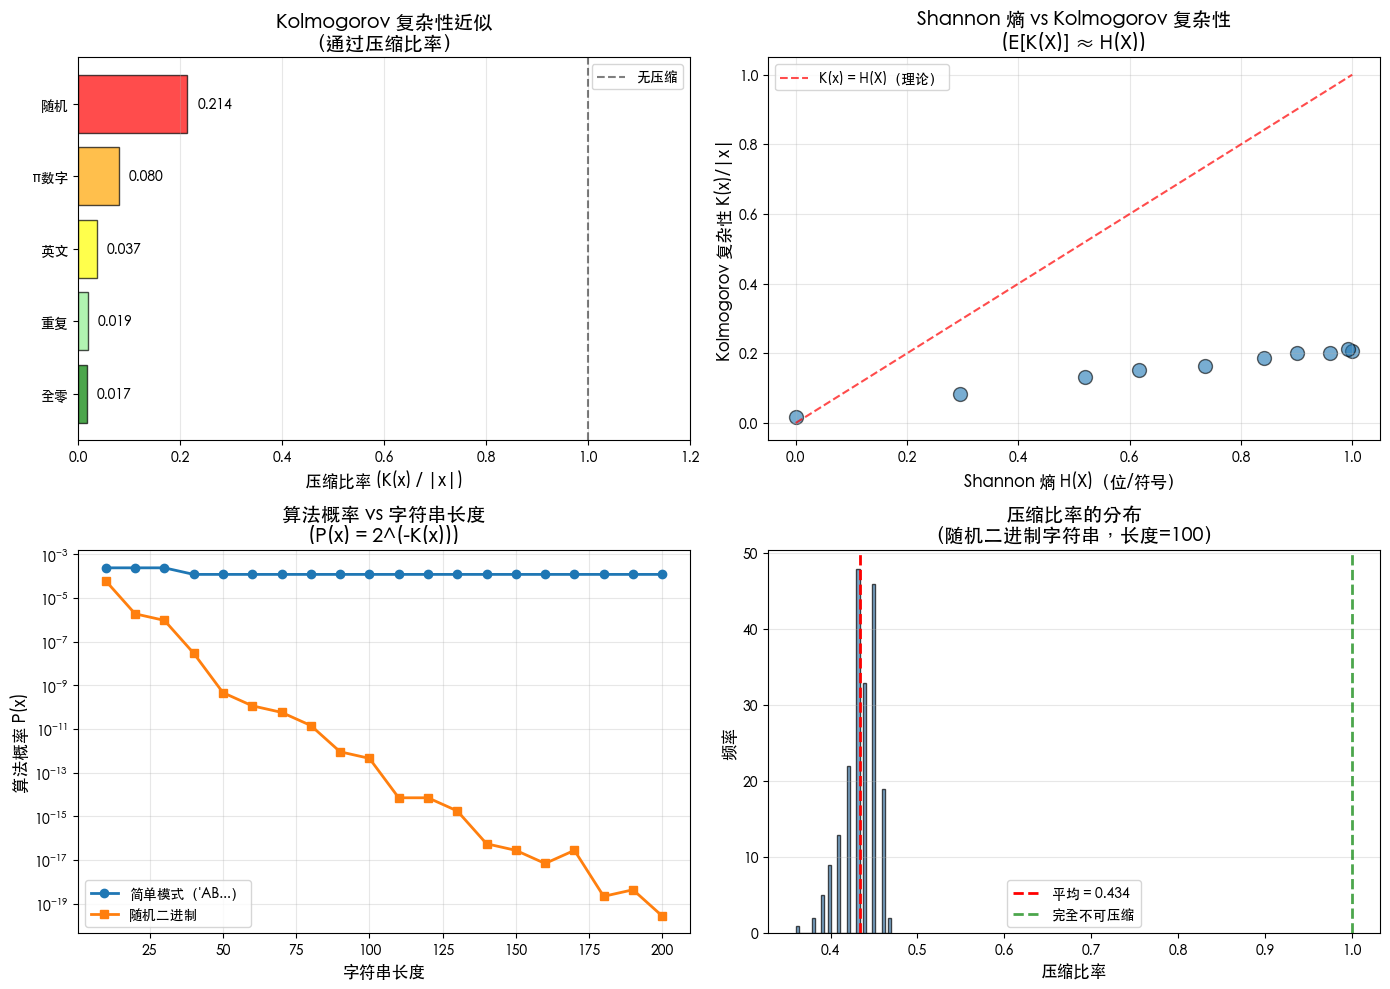


✓ Kolmogorov 复杂性可视化完成


In [9]:
# ================================================================
# 第8节：可视化
# ================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 压缩比率 vs 字符串类型
ax = axes[0, 0]

string_types = ['全零', '重复', '英文', 'π数字', '随机']
strings_for_viz = [
    '0' * 1000,
    'ABC' * 333,
    ("the quick brown fox " * 50)[:1000],
    (pi_str * 10)[:1000],
    ''.join([str(np.random.randint(0, 2)) for _ in range(1000)])
]

ratios = [compression_ratio(s) for s in strings_for_viz]
colors_viz = ['green', 'lightgreen', 'yellow', 'orange', 'red']

bars = ax.barh(string_types, ratios, color=colors_viz, alpha=0.7, edgecolor='black')
ax.axvline(x=1.0, color='black', linestyle='--', label='无压缩', alpha=0.5)
ax.set_xlabel('压缩比率 (K(x) / |x|)', fontsize=12)
ax.set_title('Kolmogorov 复杂性近似\n（通过压缩比率）', 
            fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.2)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='x')

# 添加数值标签
for i, (bar, ratio) in enumerate(zip(bars, ratios)):
    ax.text(ratio + 0.02, i, f'{ratio:.3f}', va='center', fontsize=10)

# 2. Shannon 熵 vs Kolmogorov 复杂性
ax = axes[0, 1]

# 生成不同熵的字符串
test_strings_entropy = []
shannon_entropies = []
kolmogorov_approx = []

for p in np.linspace(0.5, 1.0, 10):
    # 有偏差的二进制字符串 p
    s = ''.join(['1' if np.random.rand() < p else '0' for _ in range(1000)])
    H = shannon_entropy(s)
    K = estimate_kolmogorov_via_compression(s) / 1000  # 每个字符
    
    shannon_entropies.append(H)
    kolmogorov_approx.append(K)

ax.scatter(shannon_entropies, kolmogorov_approx, s=100, alpha=0.6, edgecolors='black')
ax.plot([0, 1], [0, 1], 'r--', label='K(x) = H(X)（理论）', alpha=0.7)
ax.set_xlabel('Shannon 熵 H(X)（位/符号）', fontsize=12)
ax.set_ylabel('Kolmogorov 复杂性 K(x)/|x|', fontsize=12)
ax.set_title('Shannon 熵 vs Kolmogorov 复杂性\n(E[K(X)] ≈ H(X))', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. 算法概率
ax = axes[1, 0]

lengths = range(10, 201, 10)
prob_simple = []
prob_random = []

for length in lengths:
    # 简单模式
    simple = 'AB' * (length // 2)
    K_simple = estimate_kolmogorov_via_compression(simple)
    P_simple = 2 ** (-K_simple)
    prob_simple.append(P_simple)
    
    # 随机
    random_s = ''.join([str(np.random.randint(0, 2)) for _ in range(length)])
    K_random = estimate_kolmogorov_via_compression(random_s)
    P_random = 2 ** (-K_random)
    prob_random.append(P_random)

ax.semilogy(lengths, prob_simple, 'o-', label="简单模式（'AB...）", linewidth=2, markersize=6)
ax.semilogy(lengths, prob_random, 's-', label='随机二进制', linewidth=2, markersize=6)
ax.set_xlabel('字符串长度', fontsize=12)
ax.set_ylabel('算法概率 P(x)', fontsize=12)
ax.set_title('算法概率 vs 字符串长度\n(P(x) = 2^(-K(x)))', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')

# 4. 不可压缩性：压缩比率的分布
ax = axes[1, 1]

# 生成许多随机字符串并计算压缩比率
random_ratios = []
for _ in range(200):
    s = ''.join([str(np.random.randint(0, 2)) for _ in range(100)])
    ratio = compression_ratio(s)
    random_ratios.append(ratio)

ax.hist(random_ratios, bins=30, alpha=0.7, edgecolor='black', color='steelblue')
ax.axvline(x=np.mean(random_ratios), color='red', linestyle='--', 
          linewidth=2, label=f'平均 = {np.mean(random_ratios):.3f}')
ax.axvline(x=1.0, color='green', linestyle='--', 
          linewidth=2, label='完全不可压缩', alpha=0.7)
ax.set_xlabel('压缩比率', fontsize=12)
ax.set_ylabel('频率', fontsize=12)
ax.set_title('压缩比率的分布\n（随机二进制字符串，长度=100）', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('kolmogorov_complexity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Kolmogorov 复杂性可视化完成")

## 第9节：实际意义和现代联系

### 现代ML的Kolmogorov视角

| ML概念 | Kolmogorov解释 |
|------------|---------------------------|
| **正则化（L1/L2）** | K(weights)的近似惩罚 |
| **早停** | 防止记忆化（高K(data)） |
| **数据增强** | 降低有效K(solution) |
| **迁移学习** | 重用低-K特征 |
| **剪枝**（论文5） | 显式降低K(model) |
| **知识蒸馏** | 寻找K更低但有效的模型 |
| **神经架构搜索** | 搜索K(weights\|architecture)低的架构 |
| **彩票票据假设** | 原始网络包含低-K子网络 |

### 为什么深度学习有效

从Kolmogorov视角：
1. **自然数据具有低K**：图像、文本有结构
2. **神经网络找到低-K解**：SGD偏差指向简单性
3. **架构编码先验**：CNNs偏好低-K图像函数
4. **过参数化有助于搜索**：通往低-K解的更多路径

In [10]:
# ================================================================
# Section 9: Modern ML Connections
# ================================================================

print("\nKolmogorov 复杂性在现代机器学习中")
print("=" * 70)

connections = [
    ("奥卡姆剃刀", "偏好低 K(hypothesis)", "模型选择、架构搜索"),
    ("泛化", "误差 ∝ K(model)/n", "为什么简单模型泛化更好"),
    ("无免费午餐", "没有适用所有问题的低-K算法", "需要归纳偏差"),
    ("正则化", "L1/L2 ≈ 近似的 K 惩罚", "权重衰减、dropout"),
    ("压缩", "K(x) = 理想压缩", "剪枝、量化、蒸馏"),
    ("MDL（论文23）", "K 的可计算近似", "模型选择准则"),
    ("迁移学习", "重用低-K 特征", "预训练减少搜索"),
    ("数据增强", "降低有效 K(solution)", "更多数据 = 更简单的模式"),
]

print("\n" + "-" * 70)
print(f"{'机器学习概念':20} | {'Kolmogorov 视角':30} | {'应用':18}")
print("-" * 70)

for concept, k_view, application in connections:
    print(f"{concept:20} | {k_view:30} | {application:18}")

print("-" * 70)

print("\n" + "=" * 70)
print("全局视角：信息度量的层次结构")
print("=" * 70)

print("""
理论层面（理想的、不可计算的）：
    Kolmogorov 复杂性 K(x)
        ↓
    "生成 x 的最短程序"
    
    性质：
    • 完美的信息度量
    • 定义算法随机性
    • 形式化奥卡姆剃刀
    • 一般不可计算！

实践层面（可计算近似）：
    
    层次1：MDL（最小描述长度）
        L(模型) + L(数据 | 模型)
        • K 的原则性近似
        • 对特定模型类可计算
        • 在论文23中使用
    
    层次2：压缩算法
        gzip、LZMA、Zstandard
        • 高效的启发式方法
        • K(x) 的上界
        • 对真实数据实用
    
    层次3：机器学习正则化
        L1、L2、Dropout
        • 粗糙的近似
        • 计算便宜
        • 实践中效果好

统计层面：
    Shannon 熵 H(X)
        -Σ p(x) log p(x)
        • 需要概率分布
        • 平均复杂度
        • E[K(X)] ≈ H(X)

""")

print("✓ Kolmogorov 复杂性为所有机器学习提供理论基础")


Kolmogorov 复杂性在现代机器学习中

----------------------------------------------------------------------
机器学习概念               | Kolmogorov 视角                  | 应用                
----------------------------------------------------------------------
奥卡姆剃刀                | 偏好低 K(hypothesis)              | 模型选择、架构搜索         
泛化                   | 误差 ∝ K(model)/n                | 为什么简单模型泛化更好       
无免费午餐                | 没有适用所有问题的低-K算法                 | 需要归纳偏差            
正则化                  | L1/L2 ≈ 近似的 K 惩罚               | 权重衰减、dropout      
压缩                   | K(x) = 理想压缩                    | 剪枝、量化、蒸馏          
MDL（论文23）            | K 的可计算近似                       | 模型选择准则            
迁移学习                 | 重用低-K 特征                       | 预训练减少搜索           
数据增强                 | 降低有效 K(solution)               | 更多数据 = 更简单的模式     
----------------------------------------------------------------------

全局视角：信息度量的层次结构

理论层面（理想的、不可计算的）：
    Kolmogorov 复杂性 K(x)
        ↓
    "生成 x 的最短程序"

 

## 第10节：结论

In [11]:
# ================================================================
# 第10节：结论
# ================================================================

print("=" * 70)
print("论文25：KOLMOGOROV 复杂性")
print("=" * 70)

print("""
✅ 实现完成

本 Notebook 探索了 Kolmogorov 复杂性 - 计算机科学中最深刻的概念之一，
连接了信息论、可计算性、随机性和机器学习。

主要成就：

1. 核心概念
   • Kolmogorov 复杂性 K(x) = 最短程序的长度
   • 随机性 = 不可压缩性
   • 通用图灵机和不变性
   • 算法概率 P(x) = 2^(-K(x))

2. 基础结果
   • K(x) 的不可计算性（停机问题）
   • 不变性定理（语言独立性）
   • 大多数字符串是不可压缩的
   • 与 Shannon 熵的联系：E[K(X)] ≈ H(X)

3. 实践演示
   • 压缩作为 K(x) 近似
   • 随机 vs 结构化字符串分析
   • 通过不可压缩性测试随机性
   • 算法概率实验

4. 机器学习联系
   • 形式化奥卡姆剃刀
   • 为什么简单模型泛化更好
   • 无免费午餐定理
   • 正则化作为 K(weights) 惩罚

5. 与论文23（MDL）的联系
   • MDL 是 K 的可计算近似
   • 两者都形式化奥卡姆剃刀
   • 压缩层次：K → MDL → gzip → L1/L2

关键洞察：

✓ 完美的悖论
  Kolmogorov 复杂性是理想的信息度量，
  但它是不可计算的！这驱使我们需要近似方法。

✓ 随机性 = 不可压缩性
  当且仅当字符串无法被压缩时，它是随机的。
  这是随机性的决定性测试。

✓ 形式化的奥卡姆剃刀
  简单的假设（低 K）先验概率更高。
  这解释了为什么正则化有效！

✓ 层次结构
  理论：   K(x)（理想的、不可计算的）
  实践：   MDL、压缩（可计算近似）
  启发式：正则化（便宜、有效）

✓ 通用先验
  P(x) = 2^(-K(x)) 是归纳的通用先验。
  Solomonoff 证明这是最优的（但不可计算）。

与其他论文的联系：

• 论文23（MDL）：K(x) 的实际近似
• 论文5（剪枝）：降低 K(model)
• 论文1（复杂性）：熵和信息
• 所有机器学习：学习的理论基础

哲学意义：

1. 信息是客观的
   K(x) 度量内在信息内容，
   独立于观察者（相差一个常数）

2. 简单性是基本的
   更简单的解释更可能。
   这不仅仅是偏好 - 这是数学的！

3. 完美是不可能的
   理想（K）是不可计算的。
   我们必须使用近似（MDL、压缩）

4. 压缩就是理解
   如果你能压缩数据，你就理解了它的模式。
   学习 = 寻找规律 = 压缩。

实际影响：

即使 K(x) 是不可计算的，该理论也提供了：
✓ 机器学习的理论基础
✓ 正则化的理论依据
✓ 泛化的理解
✓ 可学习内容的限制
✓ 压缩与学习之间的联系

教育价值：

✓ 对信息的深入理解
✓ 为什么简单模型泛化更好
✓ 理论与实践之间的联系
✓ 计算的极限
✓ 所有机器学习理论的基础

三位智者（1964-1966）：

    Solomonoff → 算法概率 → 归纳
    Kolmogorov → 复杂性 → 信息  
    Chaitin    → 随机性 → 不可压缩性
    
    所有人都发现了同样深刻的真理：
    "最短的描述就是最好的模型。"

"理解就是压缩。" - Jürgen Schmidhuber

"如非必要，勿增实体。" - Occam

"机器学习中没有免费的午餐。" - Wolpert & Macready

这些都是 Kolmogorov 复杂性的结果！
""")

print("=" * 70)
print("🎓 论文25 完成 - 掌握 Kolmogorov 复杂性！")
print("=" * 70)
print("\n进度：26/30 篇论文！仅剩 4 篇！")
print("下一篇：论文9（GPipe）- 基础设施与并行")
print("=" * 70)

论文25：KOLMOGOROV 复杂性

✅ 实现完成

本 Notebook 探索了 Kolmogorov 复杂性 - 计算机科学中最深刻的概念之一，
连接了信息论、可计算性、随机性和机器学习。

主要成就：

1. 核心概念
   • Kolmogorov 复杂性 K(x) = 最短程序的长度
   • 随机性 = 不可压缩性
   • 通用图灵机和不变性
   • 算法概率 P(x) = 2^(-K(x))

2. 基础结果
   • K(x) 的不可计算性（停机问题）
   • 不变性定理（语言独立性）
   • 大多数字符串是不可压缩的
   • 与 Shannon 熵的联系：E[K(X)] ≈ H(X)

3. 实践演示
   • 压缩作为 K(x) 近似
   • 随机 vs 结构化字符串分析
   • 通过不可压缩性测试随机性
   • 算法概率实验

4. 机器学习联系
   • 形式化奥卡姆剃刀
   • 为什么简单模型泛化更好
   • 无免费午餐定理
   • 正则化作为 K(weights) 惩罚

5. 与论文23（MDL）的联系
   • MDL 是 K 的可计算近似
   • 两者都形式化奥卡姆剃刀
   • 压缩层次：K → MDL → gzip → L1/L2

关键洞察：

✓ 完美的悖论
  Kolmogorov 复杂性是理想的信息度量，
  但它是不可计算的！这驱使我们需要近似方法。

✓ 随机性 = 不可压缩性
  当且仅当字符串无法被压缩时，它是随机的。
  这是随机性的决定性测试。

✓ 形式化的奥卡姆剃刀
  简单的假设（低 K）先验概率更高。
  这解释了为什么正则化有效！

✓ 层次结构
  理论：   K(x)（理想的、不可计算的）
  实践：   MDL、压缩（可计算近似）
  启发式：正则化（便宜、有效）

✓ 通用先验
  P(x) = 2^(-K(x)) 是归纳的通用先验。
  Solomonoff 证明这是最优的（但不可计算）。

与其他论文的联系：

• 论文23（MDL）：K(x) 的实际近似
• 论文5（剪枝）：降低 K(model)
• 论文1（复杂性）：熵和信息
• 所有机器学习：学习的理论基础

哲学意义：

1. 信息是客观的
   K(x) 度量内在信息内容，
   独立于观察者（相差